# Install Library

In [12]:
!pip install timm seaborn tqdm


# Import Library

In [13]:
# Import library
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Import library PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Cek GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU terdeteksi:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU tidak tersedia, menggunakan CPU")

device

GPU terdeteksi: Tesla T4


device(type='cuda')

# Load dataset & encode label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   filename      label
0  0001.jpg  gado_gado
1  0002.jpg  gado_gado
2  0003.jpg    rendang
3  0004.jpg      bakso
4  0005.jpg      bakso


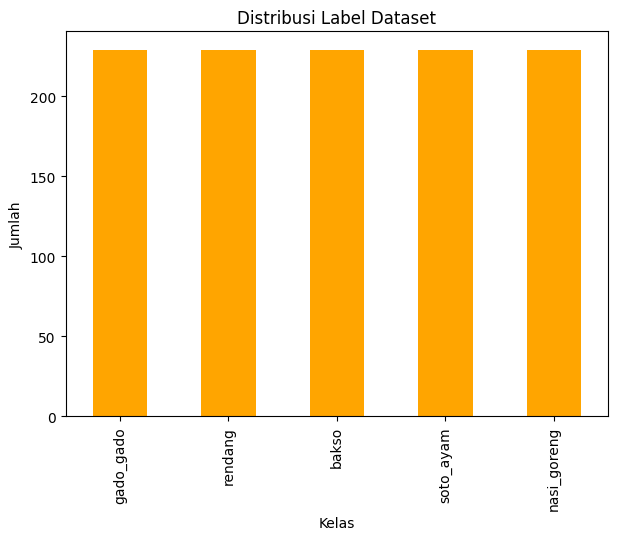

Jumlah Data Train: 916
Jumlah Data Validasi: 229
Persentase Data Train     : 80.00%
Persentase Data Validasi  : 20.00%


5

In [14]:
# Memasukkan data dan label
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/labels.csv"
img_dir  = "/content/drive/MyDrive/datasett/dataset"
df = pd.read_csv(csv_path)
print(df.head())

# Visualisasi distribusi kelas dataset
plt.figure(figsize=(7,5))
df['label'].value_counts().plot(kind='bar', color='orange')
plt.title("Distribusi Label Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split train dan validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print("Jumlah Data Train:", len(train_df))
print("Jumlah Data Validasi:", len(val_df))

# Hitung persentase
total = len(df)
train_percent = (len(train_df) / total) * 100
val_percent   = (len(val_df) / total) * 100

print(f"Persentase Data Train     : {train_percent:.2f}%")
print(f"Persentase Data Validasi  : {val_percent:.2f}%")

num_classes = len(label_encoder.classes_)
num_classes

# Class Dataset dan Augmentasi

In [15]:
# Class dataset custom untuk membaca gambar & label
class FoodDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = row['label_encoded']
        if self.transform:
            image = self.transform(image)
        return image, label

# Augmentasi untuk training
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Transformasi validasi (tanpa augmentasi)
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Membuat dataset & loader
train_ds = FoodDataset(train_df, img_dir, train_tf)
val_ds   = FoodDataset(val_df, img_dir, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


# Konfigurasi training

In [16]:
# Hyper parameter yang dibutuhkan
config = {
    "epochs": 12,
    "lr": 1e-4,
    "batch_size": 16,
    "patience": 3,
    "device": device,
    "save_path": "/content/drive/MyDrive/ResultDL"
}

# Membuat folder hasil jika belum ada
os.makedirs(config["save_path"], exist_ok=True)

config


{'epochs': 12,
 'lr': 0.0001,
 'batch_size': 16,
 'patience': 3,
 'device': device(type='cuda'),
 'save_path': '/content/drive/MyDrive/ResultDL'}

# Load Model

In [22]:
# Fungsi untuk parameter
def count_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# Membuat model MAE
model_mae = timm.create_model(
    "vit_base_patch16_224.mae",
    pretrained=True,
    num_classes=num_classes
)

# Freeze semua parameter
for param in model_mae.parameters():
    param.requires_grad = False

# Unfreeze classifier head
for name, param in model_mae.head.named_parameters():
    param.requires_grad = True

# Unfreeze layer normalization terakhir
for name, param in model_mae.norm.named_parameters():
    param.requires_grad = True

# Unfreeze 1 block terakhir
last_block = model_mae.blocks[-1]
for name, param in last_block.named_parameters():
    param.requires_grad = True

# Print hasil trainable
print("Trainable MAE (MLP + 1 block terakhir)")
print(count_params(model_mae))

Trainable MAE (MLP + 1 block terakhir)
(7093253, 85802501)


# Fungsi Training dan early stopping

In [23]:
# Persiapan Model dan Optimizer
def train_model(model, train_loader, val_loader, config, model_name):
    model.to(config["device"])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    # Inisialisasi Variabel
    best_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    # Loop Training per Epoch
    for epoch in range(config["epochs"]):
        model.train()
        train_loss, correct_train = 0, 0

        for x, y in train_loader:
            x, y = x.to(config["device"]), y.to(config["device"])

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(config["device"]), y.to(config["device"])
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                correct_val += (outputs.argmax(1) == y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)

        # Simpan history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{config['epochs']} "
              f"TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
              f"TrainAcc={train_acc:.4f} ValAcc={val_acc:.4f}")

        # SIMPAN MODEL TERBAIK
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{config['save_path']}/{model_name}_best.pth")
            print(f"Model terbaik {model_name} disimpan!")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print("Early stopping aktif!")
            break

    return model, history


# Training Model

In [24]:
history_dict = {}
model_mae, hist_mae = train_model(model_mae, train_loader, val_loader, config, "mae")
history_dict["mae"] = hist_mae

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[mae] Epoch 1/12 TrainLoss=1.5771 ValLoss=1.4612 TrainAcc=0.2697 ValAcc=0.3537
Model terbaik mae disimpan!
[mae] Epoch 2/12 TrainLoss=0.9757 ValLoss=0.4623 TrainAcc=0.6638 ValAcc=0.8777
Model terbaik mae disimpan!
[mae] Epoch 3/12 TrainLoss=0.2723 ValLoss=0.1929 TrainAcc=0.9083 ValAcc=0.9345
Model terbaik mae disimpan!
[mae] Epoch 4/12 TrainLoss=0.1064 ValLoss=0.1403 TrainAcc=0.9672 ValAcc=0.9563
Model terbaik mae disimpan!
[mae] Epoch 5/12 TrainLoss=0.0584 ValLoss=0.2556 TrainAcc=0.9847 ValAcc=0.9389
[mae] Epoch 6/12 TrainLoss=0.0473 ValLoss=0.1491 TrainAcc=0.9836 ValAcc=0.9694
[mae] Epoch 7/12 TrainLoss=0.0256 ValLoss=0.1325 TrainAcc=0.9924 ValAcc=0.9563
Model terbaik mae disimpan!
[mae] Epoch 8/12 TrainLoss=0.0126 ValLoss=0.1408 TrainAcc=0.9978 ValAcc=0.9607
[mae] Epoch 9/12 TrainLoss=0.0102 ValLoss=0.1431 TrainAcc=0.9989 ValAcc=0.9563
[mae] Epoch 10/12 TrainLoss=0.0378 ValLoss=0.2194 TrainAcc=0.9858 ValAcc=0.9389
Early stopping aktif!


# Plot Kurva

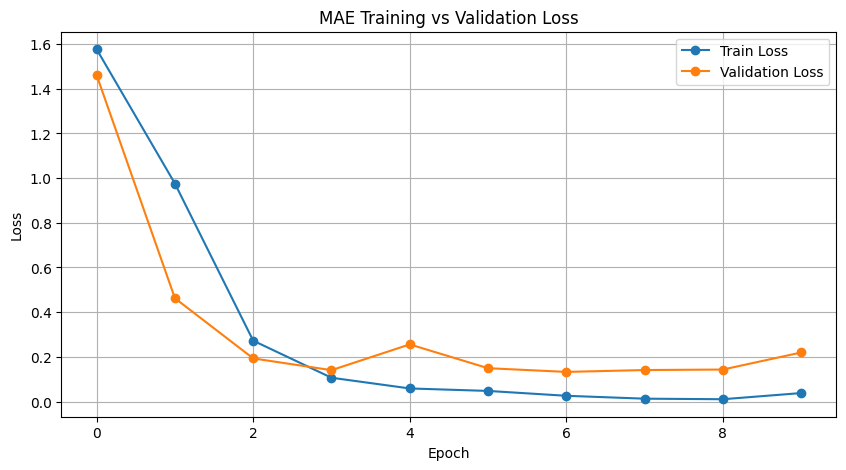

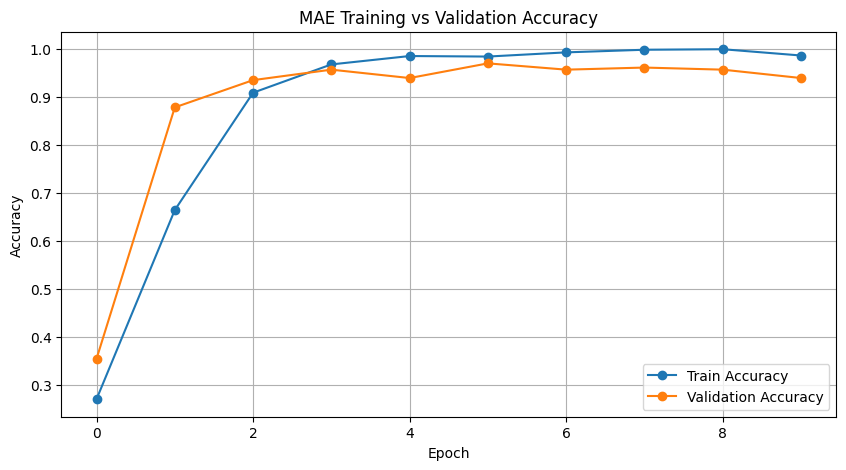

In [25]:
hist = history_dict["mae"]

# Plot Loss Curve
plt.figure(figsize=(10,5))
plt.plot(hist["train_loss"], label="Train Loss", marker='o')
plt.plot(hist["val_loss"], label="Validation Loss", marker='o')
plt.title("MAE Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10,5))
plt.plot(hist["train_acc"], label="Train Accuracy", marker='o')
plt.plot(hist["val_acc"], label="Validation Accuracy", marker='o')
plt.title("MAE Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# Evaluasi

Evaluating mae: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



 mae
              precision    recall  f1-score   support

       bakso       0.98      0.93      0.96        46
   gado_gado       0.79      1.00      0.88        45
 nasi_goreng       0.98      0.96      0.97        46
     rendang       1.00      0.93      0.97        46
   soto_ayam       1.00      0.87      0.93        46

    accuracy                           0.94       229
   macro avg       0.95      0.94      0.94       229
weighted avg       0.95      0.94      0.94       229



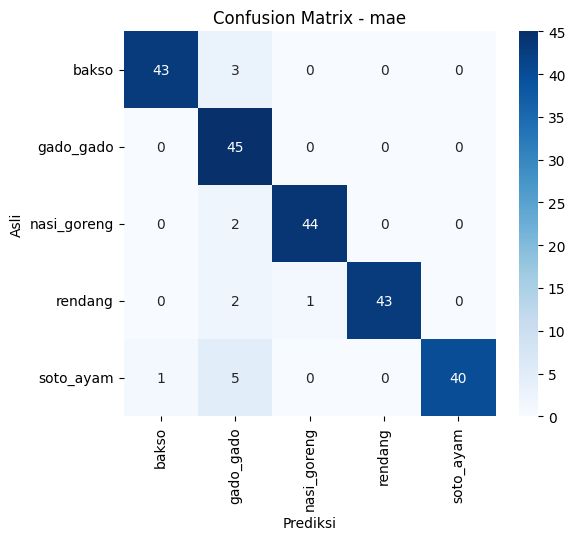

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, model_name):
    preds, trues = [], []
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Evaluating {model_name}", leave=True):
            x = x.to(device)
            out = model(x)

            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(y.numpy())

    print(f"\n {model_name}")
    print(classification_report(
        trues, preds,
        target_names=label_encoder.classes_
    ))

    cm = confusion_matrix(trues, preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Asli")
    plt.show()

evaluate_model(model_mae, "mae")

In [27]:
def measure_inference_time(model, model_name, test_loader, num_warmup=10, num_test=200):
    model.eval()

    print(f"\n{'='*50}")
    print(f"INFERENCE TIME MEASUREMENT - {model_name}")
    print(f"{'='*50}")

    print(f"Warming up GPU dengan {num_warmup} batch...")
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_warmup:
                break
            images = images.to(device)
            _ = model(images)

    times = []
    total_images = 0

    print(f"Mengukur waktu inferensi untuk {num_test} gambar...")
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Measuring", leave=False):
            if total_images >= num_test:
                break

            images = images.to(device)
            batch_size = images.size(0)

            start_time = time.time()
            _ = model(images)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()

            batch_time = (end_time - start_time) / batch_size
            times.append(batch_time)
            total_images += batch_size

    times = np.array(times)
    avg_time_sec = np.mean(times)
    std_time_sec = np.std(times)
    avg_time_ms = avg_time_sec * 1000
    std_time_ms = std_time_sec * 1000
    throughput = 1.0 / avg_time_sec

    total_test_images = len(test_loader.dataset)
    total_time_sec = avg_time_sec * total_test_images

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        hardware = f"GPU: {gpu_name} ({gpu_memory:.1f} GB)"
    else:
        import platform
        hardware = f"CPU: {platform.processor()}"

    print(f"\n HASIL PENGUKURAN:")
    print(f"{'─'*50}")
    print(f"Hardware              : {hardware}")
    print(f"Jumlah gambar diukur  : {total_images}")
    print(f"{'─'*50}")
    print(f"  Waktu per gambar    : {avg_time_ms:.2f} ± {std_time_ms:.2f} ms")
    print(f" Throughput          : {throughput:.2f} gambar/detik")
    print(f" Waktu total test set: {total_time_sec:.2f} detik ({total_test_images} gambar)")
    print(f"{'='*50}\n")

    return {
        'model_name': model_name,
        'hardware': hardware,
        'avg_time_ms': avg_time_ms,
        'std_time_ms': std_time_ms,
        'avg_time_sec': avg_time_sec,
        'throughput': throughput,
        'total_test_time_sec': total_time_sec,
        'total_images_measured': total_images,
        'total_test_images': total_test_images
    }

# GUNAKAN FUNGSI
inference_results_mae = measure_inference_time(
    model=model_mae,
    model_name="MAE Transformer",
    test_loader=val_loader,
    num_warmup=10,
    num_test=200
)


INFERENCE TIME MEASUREMENT - MAE Transformer
Warming up GPU dengan 10 batch...
Mengukur waktu inferensi untuk 200 gambar...



 HASIL PENGUKURAN:
──────────────────────────────────────────────────
Hardware              : GPU: Tesla T4 (14.7 GB)
Jumlah gambar diukur  : 208
──────────────────────────────────────────────────
  Waktu per gambar    : 10.51 ± 0.09 ms
 Throughput          : 95.17 gambar/detik
 Waktu total test set: 2.41 detik (229 gambar)

